# VC - Entrega P2

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from typing_extensions import override

In [2]:
img = cv2.imread('mandril.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
canny = cv2.Canny(gris, 100, 200)

### 1 - Contar los bordes por filas y mostrar las filas con bordes por el encima de 90% del máximo

(0.0, 512.0)

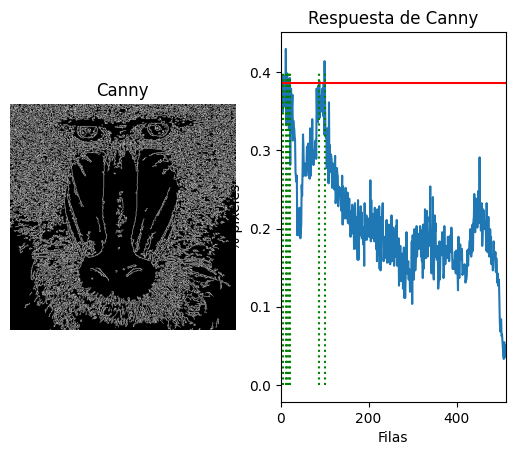

In [3]:
borders_by_row_sum = cv2.reduce(canny, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
borders_by_row_ratio = borders_by_row_sum[:, 0] / (255 * canny.shape[1])
max_border_number = np.max(borders_by_row_ratio)

rows_over_threshold = np.where(borders_by_row_ratio > 0.9 * max_border_number)[0]

plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Canny")
plt.imshow(canny, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Respuesta de Canny")
plt.xlabel("Filas")
plt.ylabel("% píxeles")
plt.plot(borders_by_row_ratio)
plt.axhline(y=max_border_number*0.9, color='r')

plt.vlines(x=rows_over_threshold, ymin=0, ymax=0.4, color='g', linestyle=':', label='Rows over threshold')
plt.xlim([0, canny.shape[0]])



2. TAREA: Aplica umbralizado a la imagen resultante de Sobel (convertida a 8 bits), y posteriormente realiza el conteo por filas y columnas similar al realizado en el ejemplo con la salida de Canny de píxeles no nulos. Calcula el valor máximo de la cuenta por filas y columnas, y determina las filas y columnas por encima del 0.90*máximo. Remarca con alguna primitiva gráfica dichas filas y columnas sobre la imagen del mandril. ¿Cómo se comparan los resultados obtenidos a partir de Sobel y Canny?

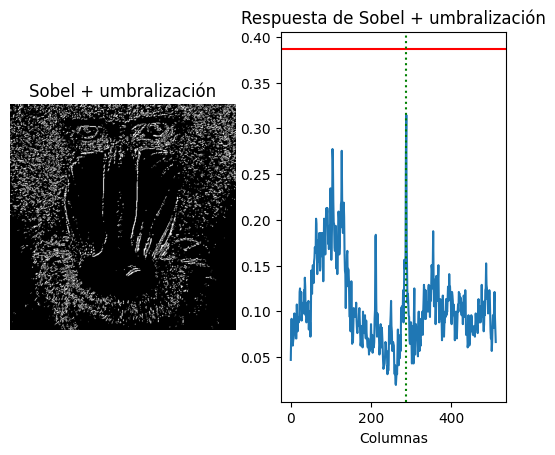

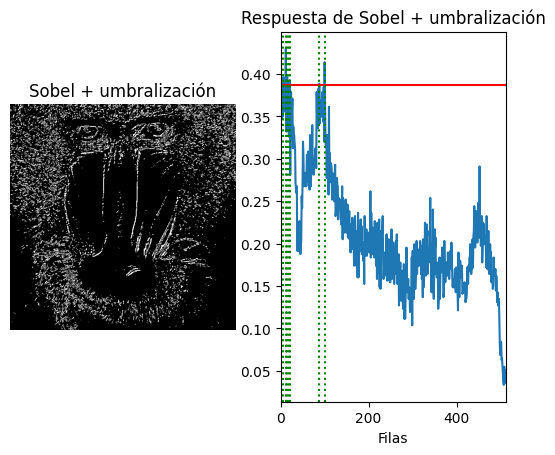

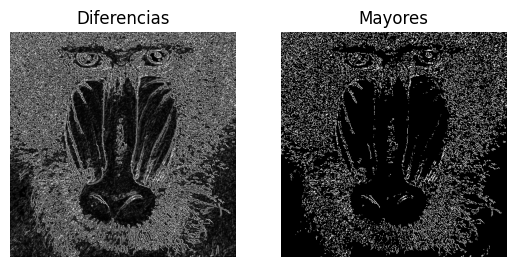

In [4]:
# Gaussiana para suavizar la imagen original, eliminando altas frecuencias
ggris = cv2.GaussianBlur(gris, (3, 3), 0)
gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
canny = cv2.Canny(gris, 100, 200)

#Calcula en ambas direcciones (horizontal y vertical)
sobelx = cv2.Sobel(ggris, cv2.CV_64F, 1, 0)  # x
sobely = cv2.Sobel(ggris, cv2.CV_64F, 0, 1)  # y
#Combina ambos resultados
sobel = cv2.add(sobelx, sobely)
sobel8np = np.uint8(np.abs(sobel))

#Umbralizamos la imagen de 8 bits del mandril
valorUmbral = 130
_, imagenUmbralizada8np = cv2.threshold(sobel8np, valorUmbral, 255, cv2.THRESH_BINARY)
#Conteo en columnas
col_counts = cv2.reduce(imagenUmbralizada8np,0,cv2.REDUCE_SUM,dtype=cv2.CV_32SC1)
cols = col_counts[0]/(255*imagenUmbralizada8np.shape[0])

plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Sobel + umbralización")
plt.imshow(imagenUmbralizada8np, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Respuesta de Sobel + umbralización")
plt.xlabel("Columnas")
plt.ylabel("% píxeles")
plt.plot(cols)
plt.axhline(y=max_border_number*0.9, color='r')
max_border_number = max(cols)
for i in range(len(cols)):
    if cols[i] > max_border_number*0.9:
        plt.axvline(x=i, color='g', linestyle=':')



row_counts = cv2.reduce(canny, 1, cv2.REDUCE_SUM, dtype=cv2.CV_32SC1)
rows =[row_counts[i][0] / (255 * canny.shape[1]) for i in range(canny.shape[0])]
max_border_number = max(rows)



plt.figure()
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Sobel + umbralización")
plt.imshow(imagenUmbralizada8np, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Respuesta de Sobel + umbralización")
plt.xlabel("Filas")
plt.ylabel("% píxeles")
plt.plot(rows)
plt.axhline(y=max_border_number*0.9, color='r')

for i in range(len(rows)):
    if rows[i] > max_border_number*0.9:
        plt.axvline(x=i, color='g', linestyle=':')

plt.xlim([0, imagenUmbralizada8np.shape[0]])

dif = cv2.absdiff(canny,sobel8np)

#Visualiza
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Diferencias")
plt.axis("off")
plt.imshow(dif, cmap='gray') 

#Zonas de mayor diferencia tras aplicar umbral
res, imgdif = cv2.threshold(dif, 160, 255, cv2.THRESH_BINARY)
#Visualiza
plt.subplot(1, 2, 2)
plt.title("Mayores")
plt.axis("off")
plt.imshow(imgdif, cmap='gray') 
plt.show()


3. TAREA: Proponer un demostrador que capture las imágenes de la cámara, y les permita exhibir lo aprendido en estas dos prácticas ante quienes no cursen la asignatura :). Es por ello que además de poder mostrar la imagen original de la webcam, permita cambiar de modo, incluyendo al menos dos procesamientos diferentes como resultado de aplicar las funciones de OpenCV trabajadas hasta ahora.

In [5]:
from abc import ABC, abstractmethod

class CameraFilter(ABC):
    def __init__(self, width, height):
        self.width = width
        self.height = height

    @abstractmethod
    def apply_to_image(self, current_frame):
        pass

class CannyCameraFilter(CameraFilter):
    def __init__(self, width, height, threshold1=100, threshold2=200):
        super().__init__(width, height)
        self.threshold1 = threshold1
        self.threshold2 = threshold2

    def apply_to_image(self, current_frame):
        gray_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray_frame, self.threshold1, self.threshold2)
        edges_bgr = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        return edges_bgr
    
class NoCameraFilter(CameraFilter):
    def __init__(self, width, height):
        super().__init__(width, height)

    def apply_to_image(self, current_frame):
        return current_frame

class AnotherCameraFilter(CameraFilter):
    def __init__(self, width, height):
        super().__init__(width, height)

    def apply_to_image(self, current_frame):
        return current_frame



class MinecraftCameraFilter(CameraFilter):
    texture_directory = "textures/"
    EMPTY_LOOKUP = 255

    minecraft_block_size = 16
    minecraft_block_textures = []
    minecraft_block_colors = []
    # Pequeña optimización a coste de 16MB de memoria. Se guardan los colores ya computados
    lookup_table = np.full((256,256,256), EMPTY_LOOKUP, dtype=np.uint8)
    def __init__(self, width, height, filter_rows, filter_columns):
        super().__init__(width, height)
        self.rows = filter_rows
        self.columns = filter_columns
        self.buffer = np.zeros((self.height, self.width, 3), dtype=np.uint8)

    @staticmethod
    def average_color(img):
        return np.array(np.mean(img, axis=(0,1)).astype(int))

    @staticmethod
    def load_textures(texture_directory):
        # Cargar texturas y clasificarlas según su color más prominente
        for filename in os.listdir(texture_directory):
            if filename.endswith(".png"):
                texture_img = cv2.imread(texture_directory + filename)
                minecraft_block_textures.append(texture_img)
                minecraft_block_colors.append(MinecraftCameraFilter.average_color(texture_img))

    # Se calcula el color de la textura más parecida
    @staticmethod
    def find_nearest_texture(color):
        r, g, b = color
        if MinecraftCameraFilter.lookup_table[r][g][b] != EMPTY_LOOKUP:
            return minecraft_block_textures[MinecraftCameraFilter.lookup_table[r][g][b]]

        distances = np.linalg.norm(minecraft_block_colors - np.array([r, g, b]), axis=1)
        best_match_index = np.argmin(distances)

        MinecraftCameraFilter.lookup_table[r][g][b] = best_match_index
        return minecraft_block_textures[best_match_index]

    def apply_to_image(self, current_frame):
        downscaled_img = cv2.resize(current_frame, (self.columns, self.rows), interpolation=cv2.INTER_NEAREST)
        for x in range(self.rows):
            for y in range(self.columns):
                # Optimización de x * 16
                minecraft_x = x << 4
                minecraft_y = y << 4
                self.buffer[minecraft_x:minecraft_x + minecraft_block_size, minecraft_y:minecraft_y + minecraft_block_size] = MinecraftCameraFilter.find_nearest_texture(downscaled_img[x][y])
        return self.buffer

MinecraftCameraFilter.load_textures(texture_directory)



NameError: name 'texture_directory' is not defined

Se coge la entrada de la cámara, se divide entre el tamaño de las texturas y se reemplaza cada pixel por el bloque que más se le parezca

In [ ]:
vid = cv2.VideoCapture(0)
is_camera_working, camera_feed = vid.read()

minecraft_rows, minecraft_columns = 0, 0
h, w = 0, 0

# Se guardan las dimensiones y se calcula el redimensionado
if is_camera_working:
    h, w, c = camera_feed.shape
    minecraft_rows = int(h/minecraft_block_size)
    minecraft_columns = int(w/minecraft_block_size)

available_filters = [
    NoCameraFilter(w, h),
    MinecraftCameraFilter(w, h, minecraft_rows, minecraft_columns),
     CannyCameraFilter(w, h, threshold1=100, threshold2=200) 
]

current_filter = 0

while is_camera_working:
    # Se cambia la resolución para obtener el efecto de pixel art, para ello se interpola con el vecino más cercano
    # Se crea muestra la cámara original a la izquierda
    cv2.imshow('Minecraft Cam', available_filters[current_filter].apply_to_image(camera_feed))
    is_camera_working, camera_feed = vid.read()

    if cv2.waitKey(1) & 0xFF == ord('d'):
        current_filter = (current_filter + 1) % len(available_filters)
    if cv2.waitKey(1) & 0xFF == ord('a'):
        current_filter = (current_filter - 1) % len(available_filters)
    if cv2.waitKey(20) == 27:
        break


vid.release()
cv2.destroyAllWindows()